# Validation and cross-validation 

In this exercise you will implement a validation pipeline. 

At the end of the MSLE exercise you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, not only should you be able to anticipate the test time performance, but also have a method to compare different models.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise MSLE.

In [ ]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('mieszkania.csv', sep=',')

In [3]:
dzielnice = df['dzielnica'].unique()
dzielnica2labels = dict(zip(dzielnice, np.arange(len(dzielnice))))
df['dzielnica'] = df['dzielnica'].apply(lambda x: dzielnica2labels[x])

test = df.sample(frac=0.2)
train = df.drop(index=test.index)
validation = train.sample(frac=0.25)
train = train.drop(index=validation.index)

x_tr, y_tr = train.values[:,:-1], train.values[:,-1]
x_val, y_val = validation.values[:,:-1], validation.values[:,-1]
x_te, y_te = test.values[:,:-1], test.values[:,-1]

In [4]:
def msle(ys, ps):
    assert len(ys) == len(ps)
    before_square = np.log(ys+1) - np.log(ps+1)
    before_mean = before_square**2
    return before_mean.mean()

def calculate_weights(x, y):
  x = np.concatenate([x, np.ones(x.shape[0])[:,np.newaxis]], axis=1)
  return np.linalg.inv(x.T @ x) @ x.T @ y

def pred(x, w):
  x = np.concatenate([x, np.ones(x.shape[0])[:,np.newaxis]], axis=1)
  return np.exp(x @ w)-1

w = calculate_weights(x_tr, np.log(1+y_tr))
print('Train loss:', msle(pred(x_tr, w), y_tr))
print('Val loss:', msle(pred(x_val, w), y_val))
print('Test loss:', msle(pred(x_te, w), y_te))

#######################################################
# TODO: Implement the basic validation method,        # 
# compare MSLE on training, validation, and test sets #
#######################################################

Train loss: 0.04405073086303491
Val loss: 0.04721287228152997
Test loss: 0.06043506735181612


To make the random split validation reliable, a huge chunk of training data may be needed. To get over this problem, one may apply cross-validaiton.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [5]:
def msle(ys, ps):
    assert len(ys) == len(ps)
    before_square = np.log(ys+1) - np.log(ps+1)
    before_mean = before_square**2
    return before_mean.mean()


def linear_regression_with_msle(x_tr, y_tr, x_te):
  x_te = np.concatenate([x_te, np.ones(x_te.shape[0])[:,np.newaxis]], axis=1)
  x_tr = np.concatenate([x_tr, np.ones(x_tr.shape[0])[:,np.newaxis]], axis=1)
  w = np.linalg.inv(x_tr.T @ x_tr) @ x_tr.T @ np.log(1+y_tr)
  return np.exp(x_te @ w)-1

In [6]:
def cross_validation(n_part, df, model, loss):
  results = []
  test_idxs = np.array_split(df.sample(frac=1)\
                             .index, indices_or_sections=n_part)
  for idxs in test_idxs:
    train = df.drop(index=idxs).values
    test = df[df.index.isin(idxs)].values
    y_pred = model(train[:,:-1], train[:,-1], test[:,:-1])
    results.append(loss(y_pred, test[:,-1]))
  results = np.array(results)
  return results.mean(), results.std()

cross_validation(10, df, linear_regression_with_msle, msle)

(0.05074210505479108, 0.017864603336524693)

Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

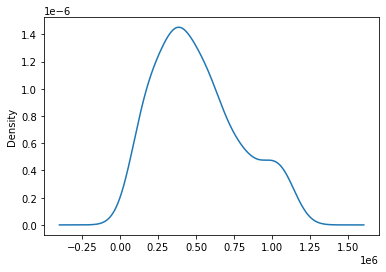

In [7]:
# check distribution of cena
df.cena.plot(kind='kde')

(0.051994927965243985, 0.007103645790938578)

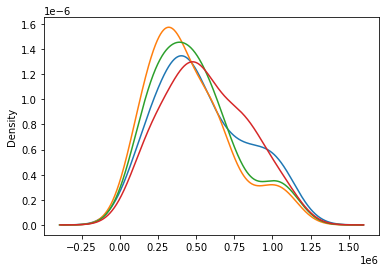

In [8]:
# check distribution of cena in each fold

def cross_validation_kde(n_part, df, model, loss):
  results = []
  test_idxs = np.array_split(df.sample(frac=1)\
                             .index, indices_or_sections=n_part)
  for idxs in test_idxs:
    train = df.drop(index=idxs).values
    test = df[df.index.isin(idxs)]
    test.cena.plot(kind='kde')
    test = test.values
    y_pred = model(train[:,:-1], train[:,-1], test[:,:-1])
    results.append(loss(y_pred, test[:,-1]))
  results = np.array(results)
  return results.mean(), results.std()

cross_validation_kde(4, df, linear_regression_with_msle, msle)

(0.05130437695325313, 0.007723051033710145)

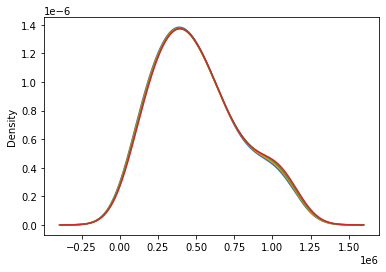

In [9]:
# Venetian Blinds Cross Validation 

def vb_cross_validation_kde_(n_part, df, model, loss):
  results = []
  sorted_values = df.cena.sort_values().reset_index()
  test_idxs = [np.random\
               .permutation(sorted_values[sorted_values.index%n_part==i]\
                            ['index'].values) for i in range(n_part)]
  for idxs in test_idxs:
    train = df.drop(index=idxs).values
    test = df[df.index.isin(idxs)]
    test.cena.plot(kind='kde')
    test = test.values
    y_pred = model(train[:,:-1], train[:,-1], test[:,:-1])
    results.append(loss(y_pred, test[:,-1]))
  results = np.array(results)
  return results.mean(), results.std()

vb_cross_validation_kde_(4, df, linear_regression_with_msle, msle)